## Problem Statement

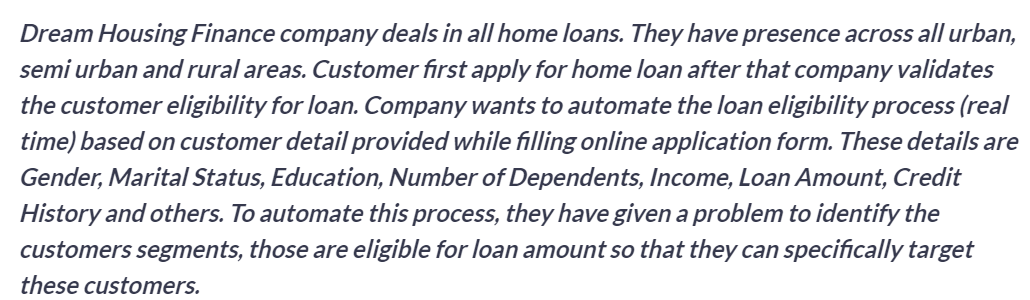

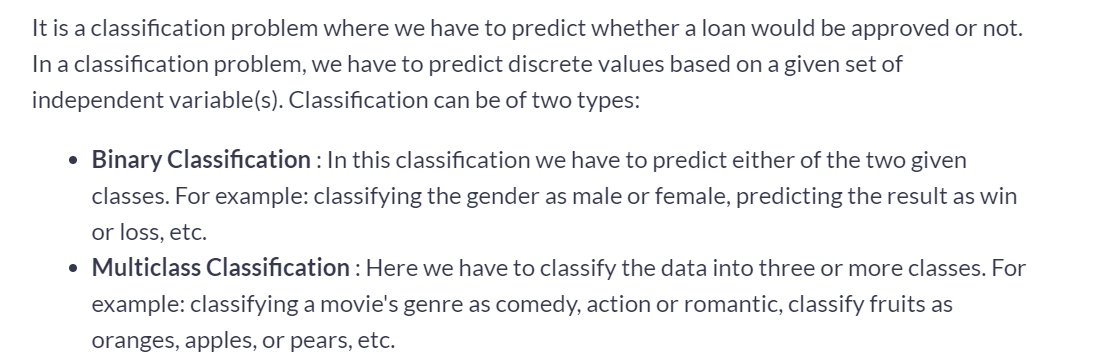

## Hypothesis 

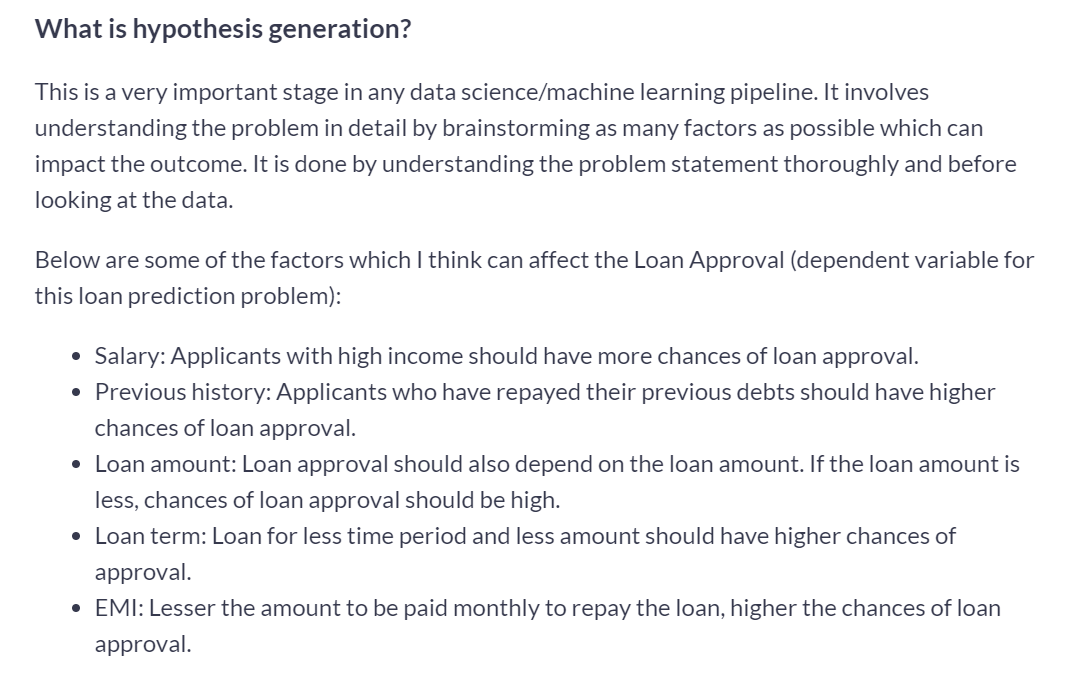

## Import Libraries

In [314]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,StratifiedKFold,GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from xgboost import XGBClassifier
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,roc_auc_score,roc_curve

import json
import pickle

import warnings
warnings.filterwarnings('ignore')

## Data Gathering

In [315]:
train = pd.read_csv('train_data.csv')
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [316]:
test = pd.read_csv('test_data.csv')
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


## EDA

In [317]:
print(train.columns)
print(test.columns)

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')
Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area'],
      dtype='object')


We have 12 dependent variables and 1 target variable
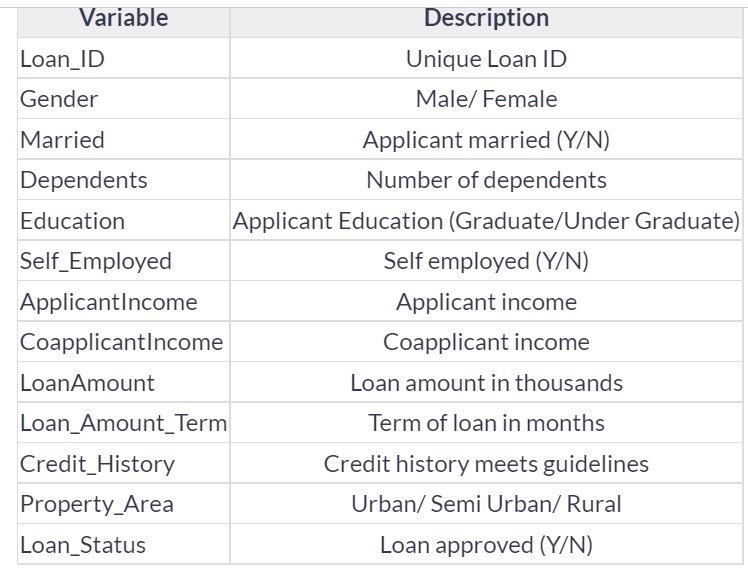

In [318]:
print(train.dtypes)
print("*"*80)
print(test.dtypes)

Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome    float64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
Loan_Status           object
dtype: object
********************************************************************************
Loan_ID               object
Gender                object
Married               object
Dependents            object
Education             object
Self_Employed         object
ApplicantIncome        int64
CoapplicantIncome      int64
LoanAmount           float64
Loan_Amount_Term     float64
Credit_History       float64
Property_Area         object
dtype: object


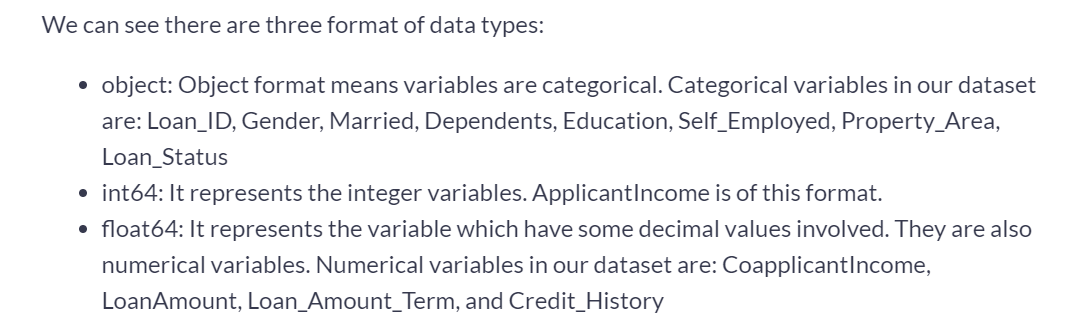

In [319]:
print(train.shape)
print(test.shape)

(614, 13)
(367, 12)


### Univariate Analysis

In [320]:
#target variable
train['Loan_Status'].value_counts()

Y    422
N    192
Name: Loan_Status, dtype: int64

In [321]:
train['Loan_Status'].value_counts(normalize=True) #to get percentage propotion

Y    0.687296
N    0.312704
Name: Loan_Status, dtype: float64

<AxesSubplot:>

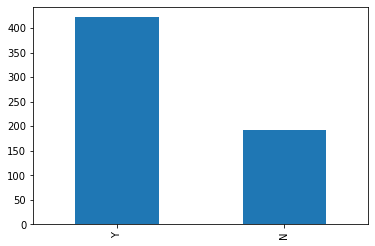

In [322]:
train['Loan_Status'].value_counts().plot.bar()

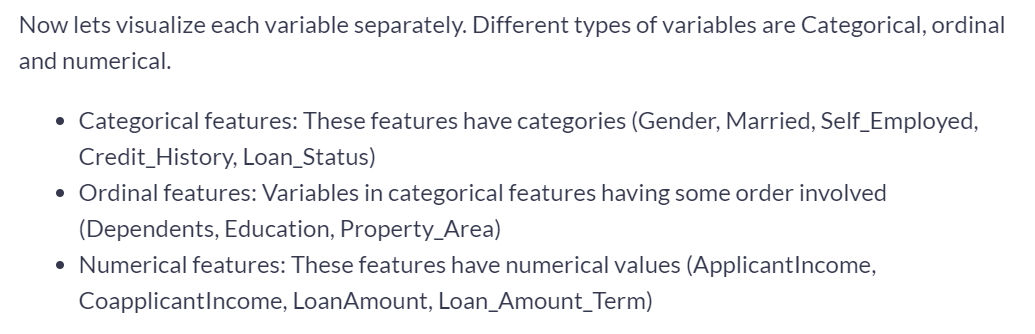

#### Grouping variables for visualization

In [323]:
def check_variable_types(data):
    #target columns
    tar_col = ['Loan_Status']

    #categorical features
    obj_cols = data.drop('Loan_Status',axis=1).select_dtypes(exclude=np.number).columns.to_list()
    cat_cols = []
    ord_cols = []

    for col in obj_cols:
        if train[col].value_counts().shape[0] == 2:
            cat_cols.append(col)
        elif train[col].value_counts().shape[0] > 2:
            ord_cols.append(col)

    #numerical features
    num_cols = data.drop('Loan_Status',axis=1).select_dtypes(include=np.number).columns.to_list()
    suspected_cat_cols = []

    #checking if any is categorial 
    for col in num_cols:
        if train[col].value_counts().shape[0] <= 5:
            print("Column name: ",col)
            print(train[col].value_counts())
            suspected_cat_cols.append(col)
            
    return tar_col,cat_cols,ord_cols,num_cols,suspected_cat_cols
    
tar_cols,cat_cols,ord_cols,num_cols,sus_cols = check_variable_types(train)

print("target Columns: ",tar_cols)
print("*"*80)
print("Categorical Columns: ",cat_cols)
print("*"*80)
print("Ordinal Columns: ",ord_cols)
print("*"*80)
print("Numerical cols: ",num_cols)
print("*"*80)
print("Suspected Categorical cols: ",sus_cols)

Column name:  Credit_History
1.0    475
0.0     89
Name: Credit_History, dtype: int64
target Columns:  ['Loan_Status']
********************************************************************************
Categorical Columns:  ['Gender', 'Married', 'Education', 'Self_Employed']
********************************************************************************
Ordinal Columns:  ['Loan_ID', 'Dependents', 'Property_Area']
********************************************************************************
Numerical cols:  ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', 'Credit_History']
********************************************************************************
Suspected Categorical cols:  ['Credit_History']


In [324]:
# We can see that Credit_History is categorical column for moving it to correct col list

cat_cols.append('Credit_History')
print("Categorical Columns: ",cat_cols)

num_cols.remove('Credit_History')
print("Updated Numerical Columns: ",num_cols)

Categorical Columns:  ['Gender', 'Married', 'Education', 'Self_Employed', 'Credit_History']
Updated Numerical Columns:  ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']


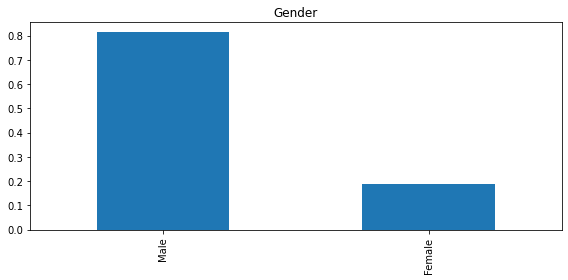

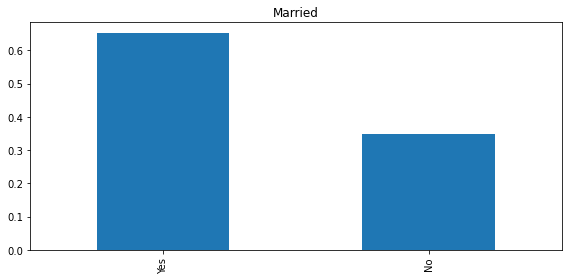

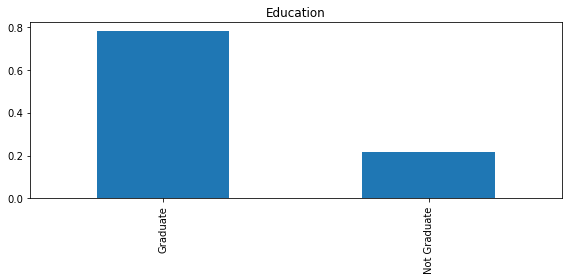

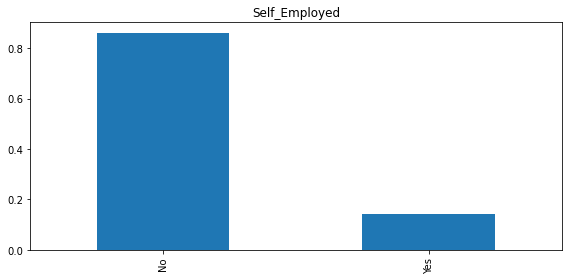

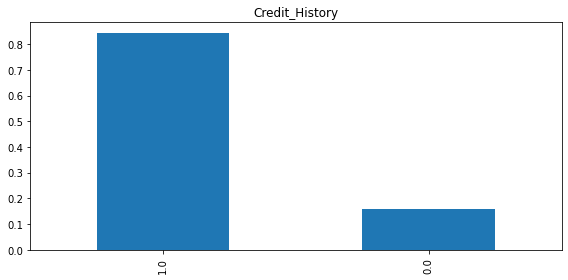

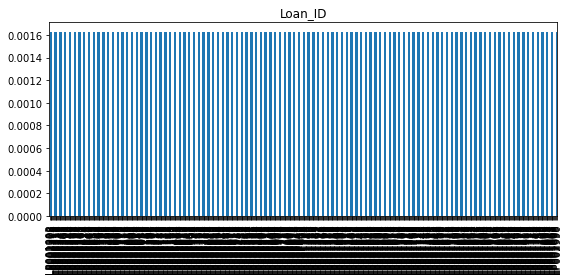

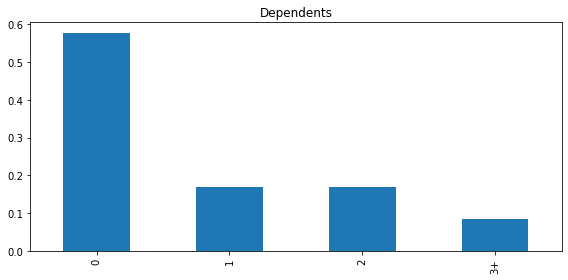

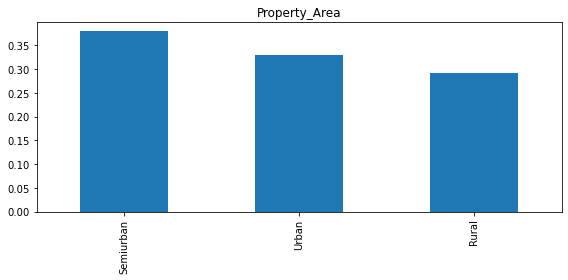

In [325]:
#visualizing the columns

def cat_col_plot(data,cols):
    for col in cols:
        plt.figure(figsize=(8,4))
        data[col].value_counts(normalize=True).plot.bar(title=col)
        plt.tight_layout()
        plt.show()
     

cat_ord_cols = cat_cols + ord_cols

cat_col_plot(train,cat_ord_cols)

- Inference
 - 80% applicants are male
 - Around 65% applicatnsta are married
 - Around 80% applicants are graduate
 - 15% are self employed
 - 85% applicants have repaid their loans
 - Most of the applicants don't have any dependents
 - Most of the applicants are from semi-urban areas

In [326]:
#loan id has all unique values hence removing it from categorical cols
ord_cols.remove('Loan_ID')
ord_cols

['Dependents', 'Property_Area']

<Figure size 720x216 with 0 Axes>

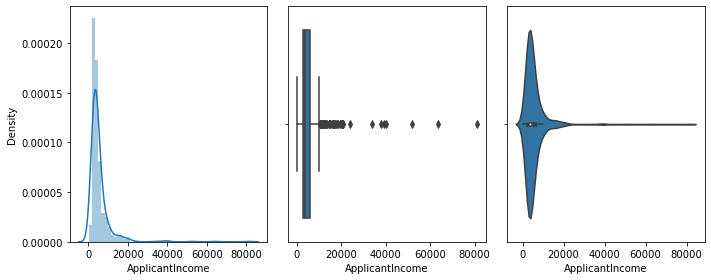

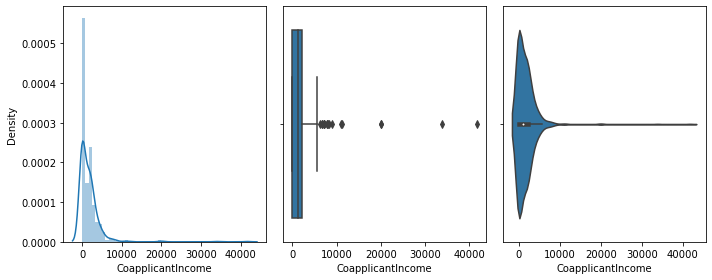

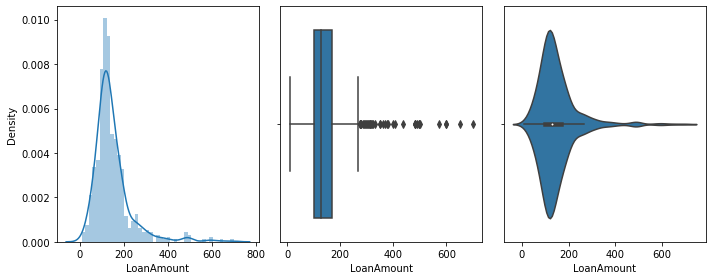

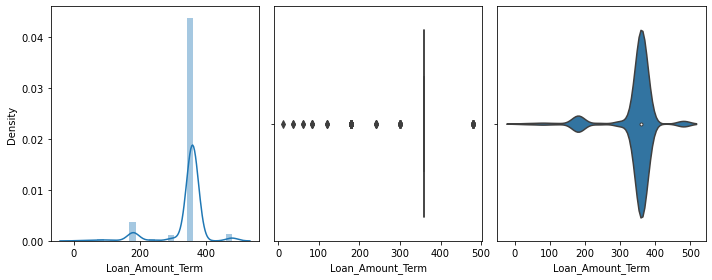

In [327]:
#numerical columns

def num_cols_plot(data,cols):
    plt.figure(figsize=(10,3))
    for i in range(0,len(cols)):
        plt.figure(figsize=(10,4))
        plt.subplot(1,3,1)
        sns.distplot(data[cols[i]],kde=True)
        plt.subplot(1,3,2)
        sns.boxplot(data[cols[i]])
        plt.subplot(1,3,3)
        sns.violinplot(data[cols[i]])
        plt.tight_layout()
        plt.show()
    
num_cols_plot(train,num_cols)

- Inference
    - Applicant Income
        - Distribution is skewed towards left so it is not normally distributed
        - Box plot confirms presence of lot of outliers or extreme values
        - That can be due to income disparity in society or we are looking at different education levels
        - We can see from below ApplicantIncome plot by Education that higher number of graduates have very high income which are appearing to be outliers
        
    - Coapplicant Income
        - Similar trends like Applicant income it is not normally distributed
        - We also see a lot of outliers
        
    - LoanAmount
        - fairly normal distribution
        - We also see a lot of outliers
        
    - Loan_Amount_Term
        - left skewed not normally distributed
        - We also see a lot of outliers mainly due to majority applicants go with particular loan term

Text(0.5, 0.98, '')

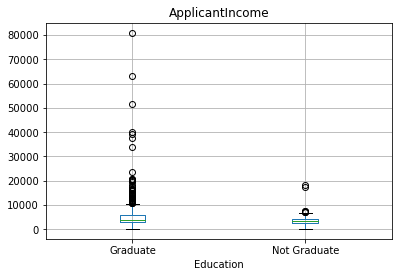

In [328]:
train.boxplot(column='ApplicantIncome',by = 'Education')
plt.suptitle("")

#### Bivariate Analysis

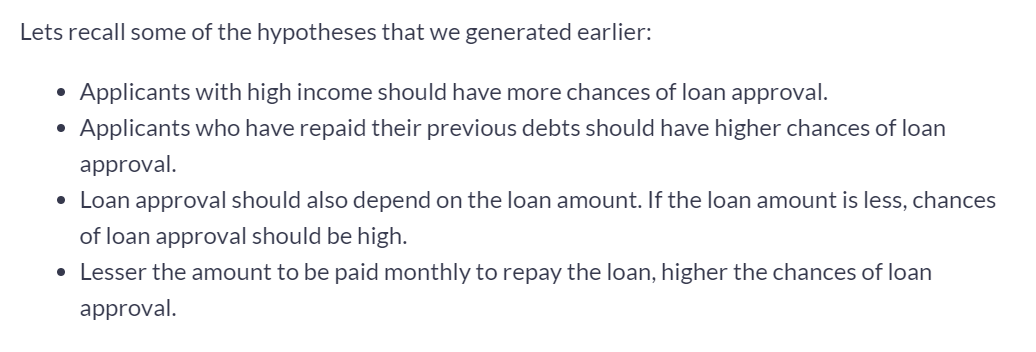

#### Categorical Independent Variable vs Target Variable

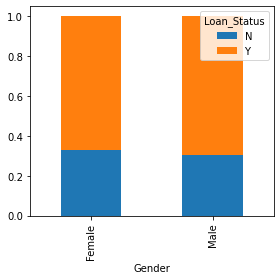

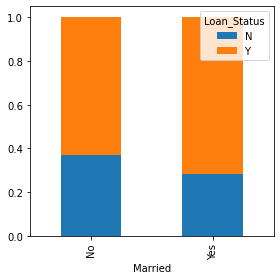

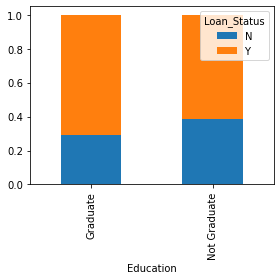

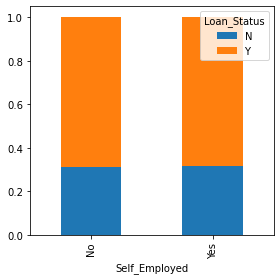

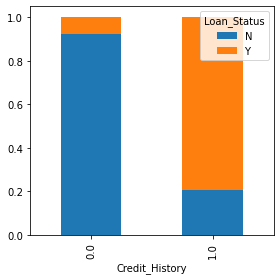

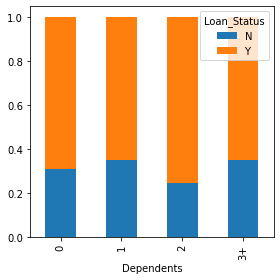

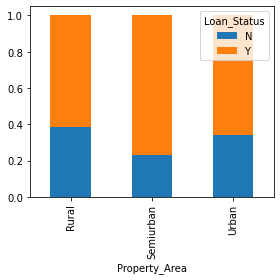

In [329]:
def cat_bivariate_stacked_plot(data,cols,target):
    for i in cols:
        col_cross = pd.crosstab(data[i],data[target[0]])
        col_cross.div(col_cross.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True,figsize=(4,4))
        plt.tight_layout()
        plt.show()
        
total_cat_cols = cat_cols + ord_cols
cat_bivariate_stacked_plot(train,total_cat_cols,tar_cols)

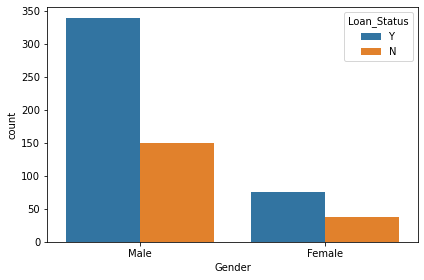

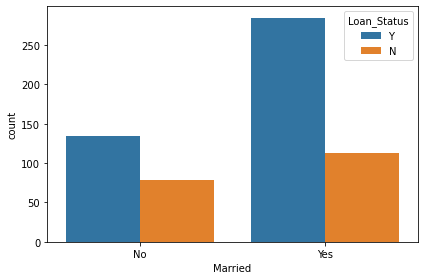

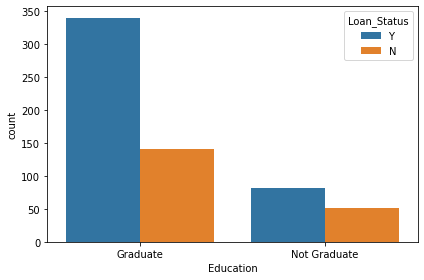

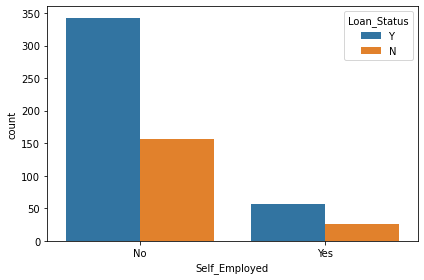

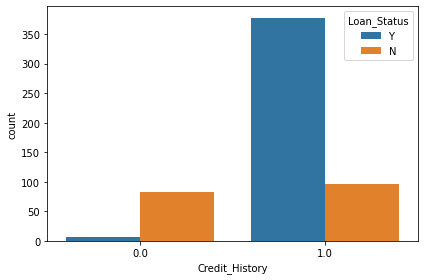

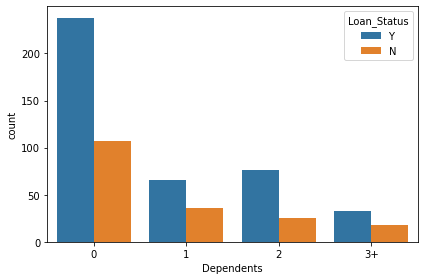

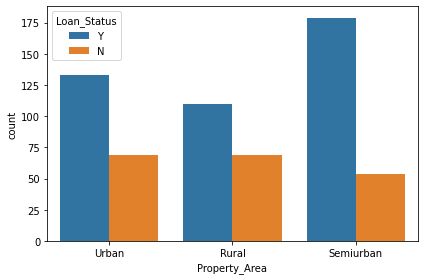

In [330]:
def cat_bivariate_column_plot(data,cols,target):
    for i in cols:
        sns.countplot(data[i],hue=data[target[0]])
        plt.tight_layout()
        plt.show()
        
total_cat_cols = cat_cols + ord_cols
cat_bivariate_column_plot(train,total_cat_cols,tar_cols)

- Inference 
    - Gender vs Loan_Status
        - Propotion of both male and female is more or less same for approved and unapproved loan
        
    - Married vs Loan_Status
        - Propotion of married applicants is higher for the approved loans
        
    - Dependents vs Loan_Status
        - Distribution of applicants with 1 or 3+ dependents is similar across both categories of loan status
        
    - Education vs Loan_Status
        - Nothing significant
        
    - Credit_History vs Loan_Status
        - Credit_History = 1 has more likely to get loan
 
    - Property_Area vs Loan_Status
        - Propotion of loan getting approved in semi urban areas is higher than urban and rural areas

#### Numerical vs Target variables

In [331]:
num_cols[0]

'ApplicantIncome'

<AxesSubplot:xlabel='Loan_Status'>

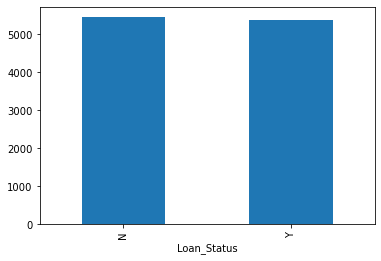

In [332]:
train.groupby('Loan_Status')['ApplicantIncome'].mean().plot.bar()

In [333]:
bins = [0,2500,4000,6000,81000]
group = ['Low','Average','High','Very High']
train['Income_bin'] = pd.cut(train['ApplicantIncome'],bins,labels=group)
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income_bin
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,High
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,High
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,Average
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,Average
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,High


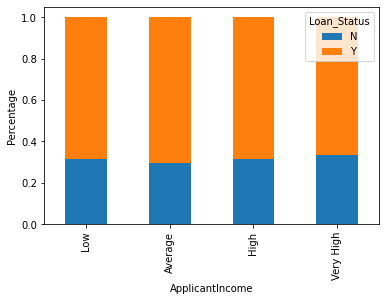

In [334]:
Income_bin = pd.crosstab(train['Income_bin'],train['Loan_Status'])
Income_bin.div(Income_bin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)
plt.xlabel('ApplicantIncome')
P = plt.ylabel('Percentage')

It can be infered that Applicant income does not affect the chances of loan approval which contradicts our hypothesis in which we assumed that if the appicant income is high the chnaces of loan approval is high 

In [335]:
bins = [0,1000,3000,42000]
group = ['Low','Average','High']
train['Coapplicant_Income_bin'] = pd.cut(train['CoapplicantIncome'],bins,labels=group)
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income_bin,Coapplicant_Income_bin
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,High,NaN
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,High,Average
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,Average,NaN
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,Average,Average
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,High,NaN


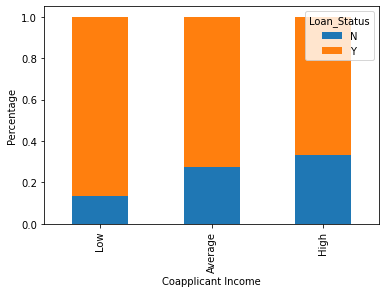

In [336]:
Coapplicant_Income_bin = pd.crosstab(train['Coapplicant_Income_bin'],train['Loan_Status'])
Coapplicant_Income_bin.div(Coapplicant_Income_bin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)
plt.xlabel('Coapplicant Income')
P = plt.ylabel('Percentage')

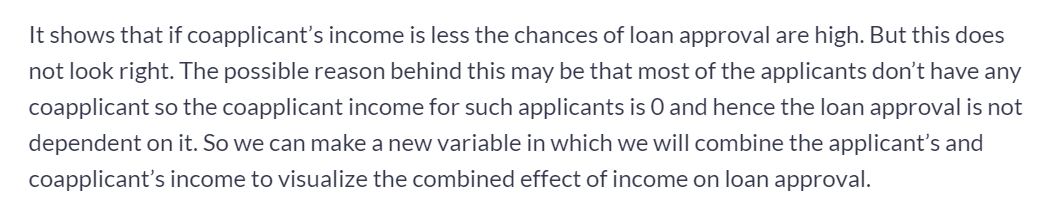

In [337]:
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']

bins = [0,2500,4000,6000,81000]
group = ['Low','Average','High','Very High']
train['Total_Income_bin'] = pd.cut(train['Total_Income'],bins,labels=group)
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income_bin,Coapplicant_Income_bin,Total_Income,Total_Income_bin
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,High,NaN,5849.0,High
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,High,Average,6091.0,Very High
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,Average,NaN,3000.0,Average
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,Average,Average,4941.0,High
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,High,NaN,6000.0,High


Text(0, 0.5, 'Percentage')

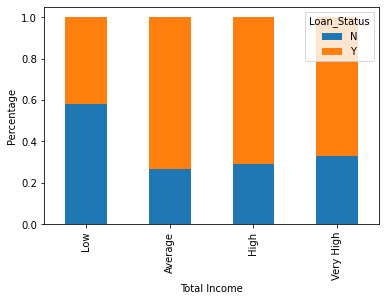

In [338]:
Total_Income_bin = pd.crosstab(train['Total_Income_bin'],train['Loan_Status'])
Total_Income_bin.div(Total_Income_bin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)
plt.xlabel('Total Income')
plt.ylabel('Percentage')

We can see that the propotion of the loans getting approved for applicants having low total income is very less as compared to that of the applicants with Average , High and Very High Income

In [339]:
train['LoanAmount'].describe()

count    592.000000
mean     146.412162
std       85.587325
min        9.000000
25%      100.000000
50%      128.000000
75%      168.000000
max      700.000000
Name: LoanAmount, dtype: float64

In [340]:
bins = [0,100,200,700]
group = ['Low','Average','High']
train['LoanAmount_bin'] = pd.cut(train['LoanAmount'],bins,labels=group)
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status,Income_bin,Coapplicant_Income_bin,Total_Income,Total_Income_bin,LoanAmount_bin
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y,High,NaN,5849.0,High,NaN
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N,High,Average,6091.0,Very High,Average
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y,Average,NaN,3000.0,Average,Low
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y,Average,Average,4941.0,High,Average
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y,High,NaN,6000.0,High,Average


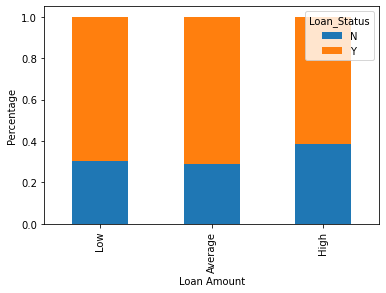

In [341]:
LoanAmount_bin = pd.crosstab(train['LoanAmount_bin'],train['Loan_Status'])
LoanAmount_bin.div(LoanAmount_bin.sum(1).astype(float),axis=0).plot(kind='bar',stacked=True)
plt.xlabel('Loan Amount')
P = plt.ylabel('Percentage')

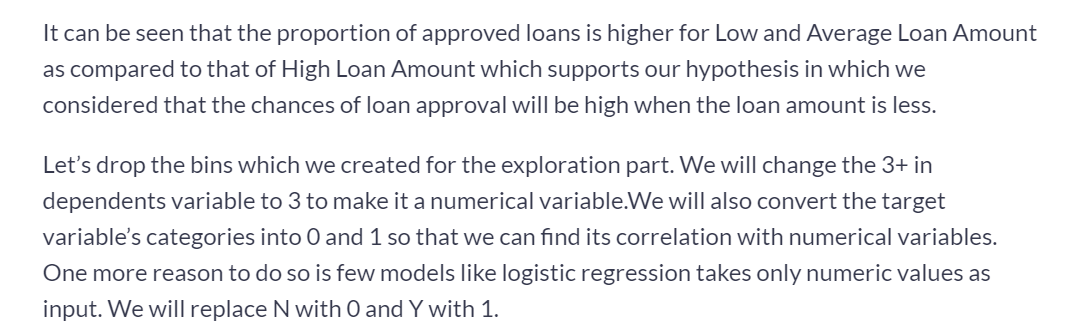

In [342]:
train.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status',
       'Income_bin', 'Coapplicant_Income_bin', 'Total_Income',
       'Total_Income_bin', 'LoanAmount_bin'],
      dtype='object')

In [343]:
train = train.drop(['Income_bin', 'Coapplicant_Income_bin', 'Total_Income', 'Total_Income_bin', 'LoanAmount_bin'],axis=1)

In [344]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


In [345]:
train['Dependents'].unique()

array(['0', '1', '2', '3+', nan], dtype=object)

In [346]:
train['Dependents'].replace('3+',3,inplace=True)
train['Dependents'].unique()

array(['0', '1', '2', 3, nan], dtype=object)

In [347]:
test['Dependents'].replace('3+',3,inplace=True)

In [348]:
train['Loan_Status'].replace({'N':0,'Y':1},inplace=True)

In [349]:
train['Loan_Status'].unique()

array([1, 0], dtype=int64)

<AxesSubplot:>

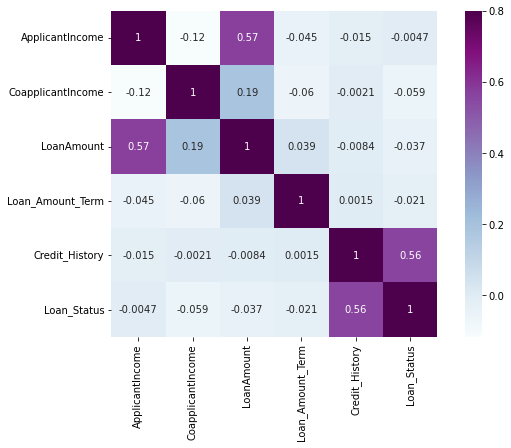

In [350]:
# Correlation between numerical columns
matrix = train.corr()
f,ax = plt.subplots(figsize=(10,6))
sns.heatmap(matrix,vmax=.8,square=True,cmap="BuPu",annot=True)

- Credit-History and Loan Status are correlated
- Applicant Income and Loan Amount are correlated
- CoApplicant Income and Loan Amount are correlated

#### Missing Value and Outlier Treatment

##### Missing Value Imupation

In [351]:
train.isnull().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [352]:
train.isnull().mean() * 100

Loan_ID              0.000000
Gender               2.117264
Married              0.488599
Dependents           2.442997
Education            0.000000
Self_Employed        5.211726
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       8.143322
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [353]:
test.isnull().mean() * 100

Loan_ID              0.000000
Gender               2.997275
Married              0.000000
Dependents           2.724796
Education            0.000000
Self_Employed        6.267030
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           1.362398
Loan_Amount_Term     1.634877
Credit_History       7.901907
Property_Area        0.000000
dtype: float64

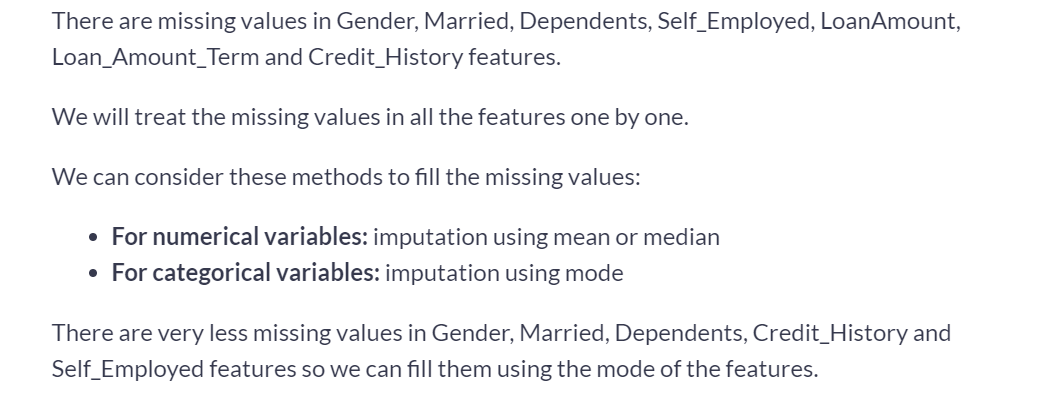

In [354]:
train['Gender'].fillna(train['Gender'].mode()[0],inplace=True)
train['Married'].fillna(train['Married'].mode()[0],inplace=True)
train['Dependents'].fillna(train['Dependents'].mode()[0],inplace=True)
train['Self_Employed'].fillna(train['Self_Employed'].mode()[0],inplace=True)
train['Credit_History'].fillna(train['Credit_History'].mode()[0],inplace=True)


In [355]:
test['Gender'].fillna(test['Gender'].mode()[0],inplace=True)
test['Married'].fillna(test['Married'].mode()[0],inplace=True)
test['Dependents'].fillna(test['Dependents'].mode()[0],inplace=True)
test['Self_Employed'].fillna(test['Self_Employed'].mode()[0],inplace=True)
test['Credit_History'].fillna(test['Credit_History'].mode()[0],inplace=True)

In [356]:
train.isnull().mean() * 100

Loan_ID              0.000000
Gender               0.000000
Married              0.000000
Dependents           0.000000
Education            0.000000
Self_Employed        0.000000
ApplicantIncome      0.000000
CoapplicantIncome    0.000000
LoanAmount           3.583062
Loan_Amount_Term     2.280130
Credit_History       0.000000
Property_Area        0.000000
Loan_Status          0.000000
dtype: float64

In [357]:
train['Loan_Amount_Term'].value_counts()

360.0    512
180.0     44
480.0     15
300.0     13
240.0      4
84.0       4
120.0      3
60.0       2
36.0       2
12.0       1
Name: Loan_Amount_Term, dtype: int64

In [358]:
# As 360 is occuring majorly we will use mode
train['Loan_Amount_Term'].fillna(train['Loan_Amount_Term'].mode()[0],inplace=True)
test['Loan_Amount_Term'].fillna(test['Loan_Amount_Term'].mode()[0],inplace=True)

In [359]:
train['LoanAmount'].fillna(train['LoanAmount'].median(),inplace=True)
test['LoanAmount'].fillna(test['LoanAmount'].median(),inplace=True)


In [360]:
train.isnull().sum()

Loan_ID              0
Gender               0
Married              0
Dependents           0
Education            0
Self_Employed        0
ApplicantIncome      0
CoapplicantIncome    0
LoanAmount           0
Loan_Amount_Term     0
Credit_History       0
Property_Area        0
Loan_Status          0
dtype: int64

###### Outlier Treatment

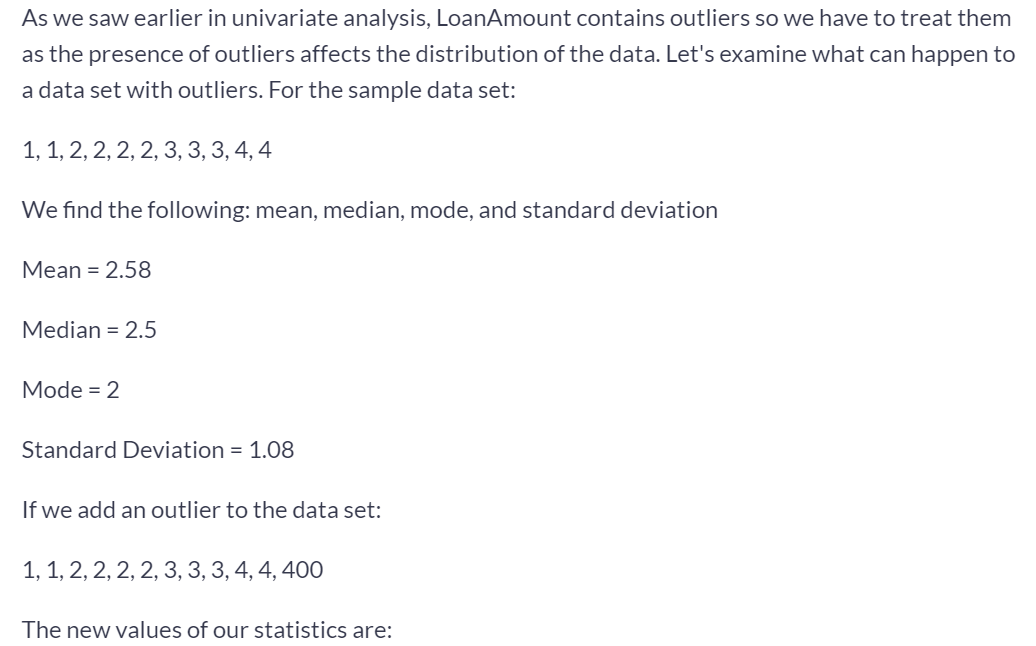

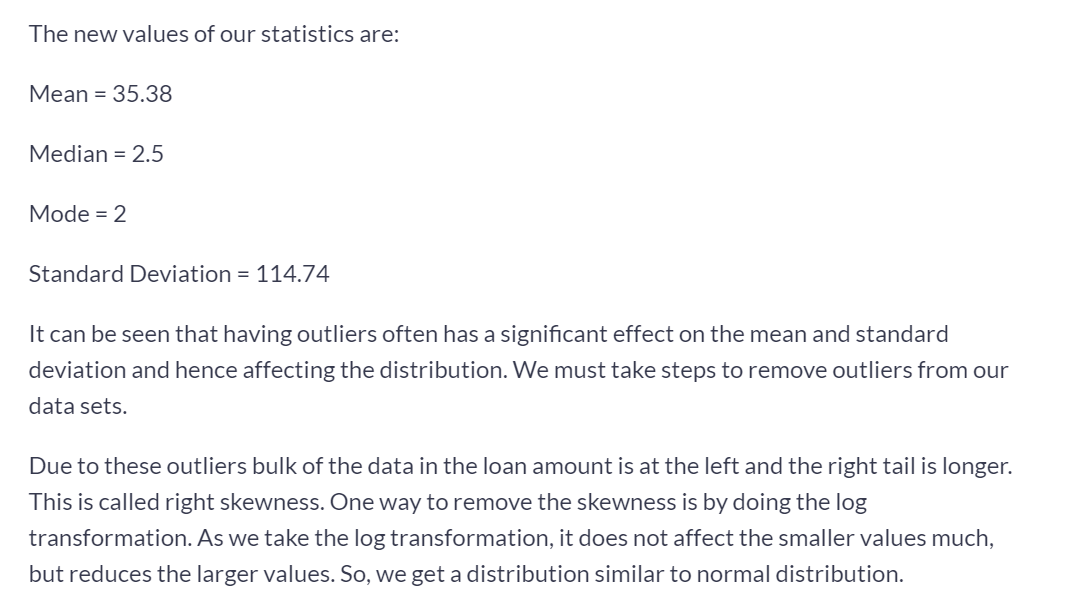

<AxesSubplot:>

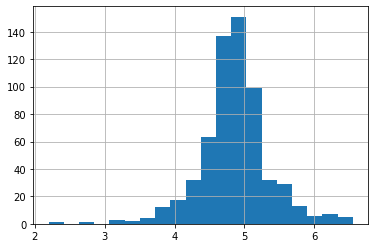

In [361]:
#trying log transform

train['LoanAmount_log'] = np.log(train['LoanAmount'])
train['LoanAmount_log'].hist(bins=20)

# Now the distribution looks much closer to normal distribution

<AxesSubplot:>

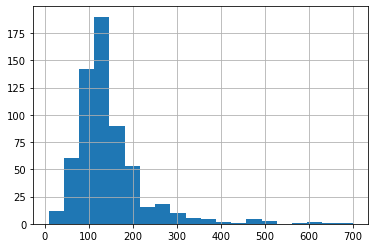

In [362]:
train['LoanAmount'].hist(bins=20)

In [363]:
test['LoanAmount_log'] = np.log(test['LoanAmount'])

## Evaluation

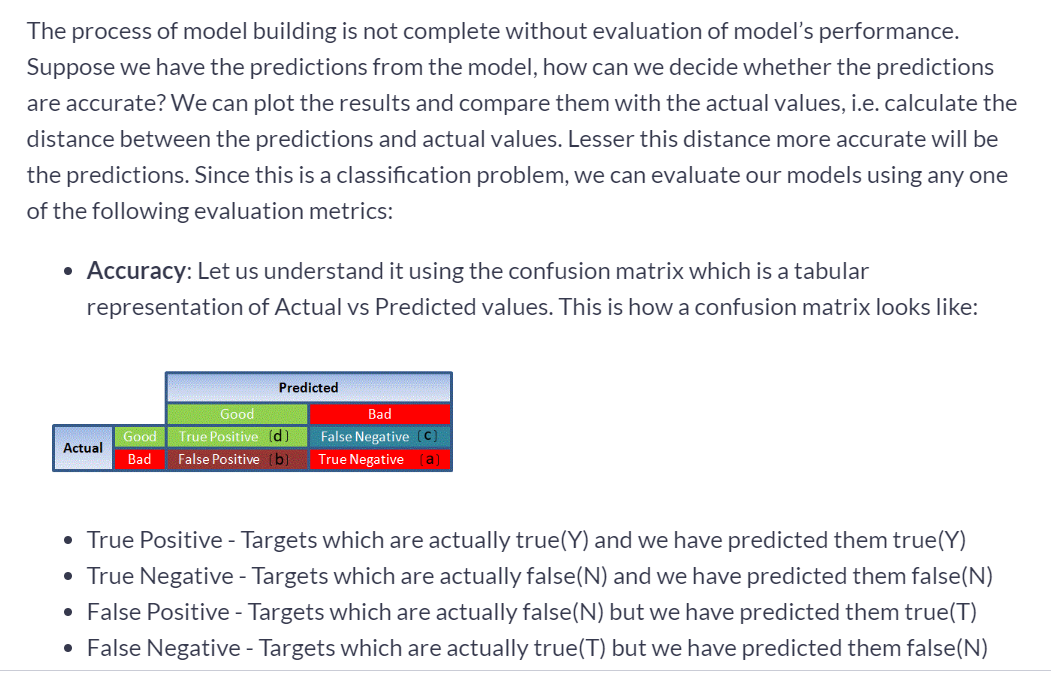
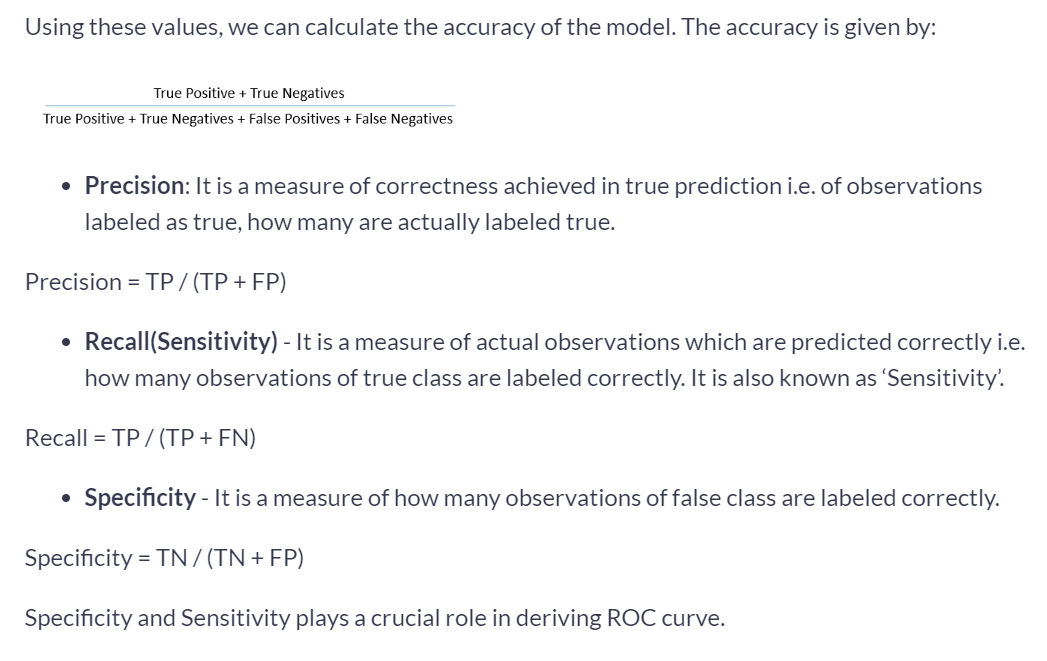
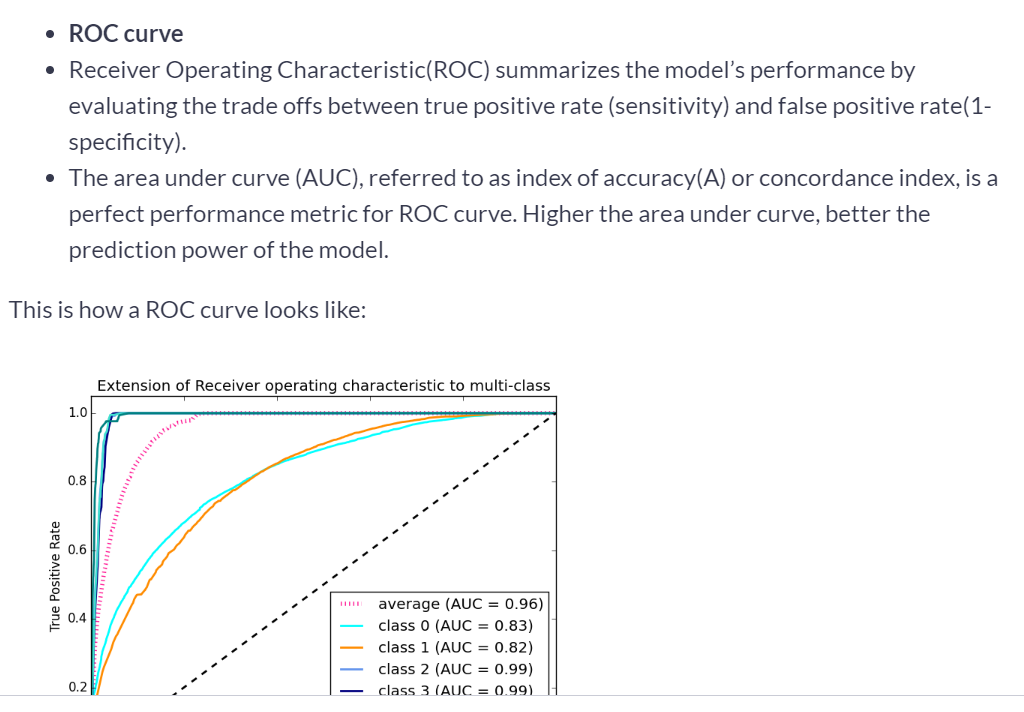
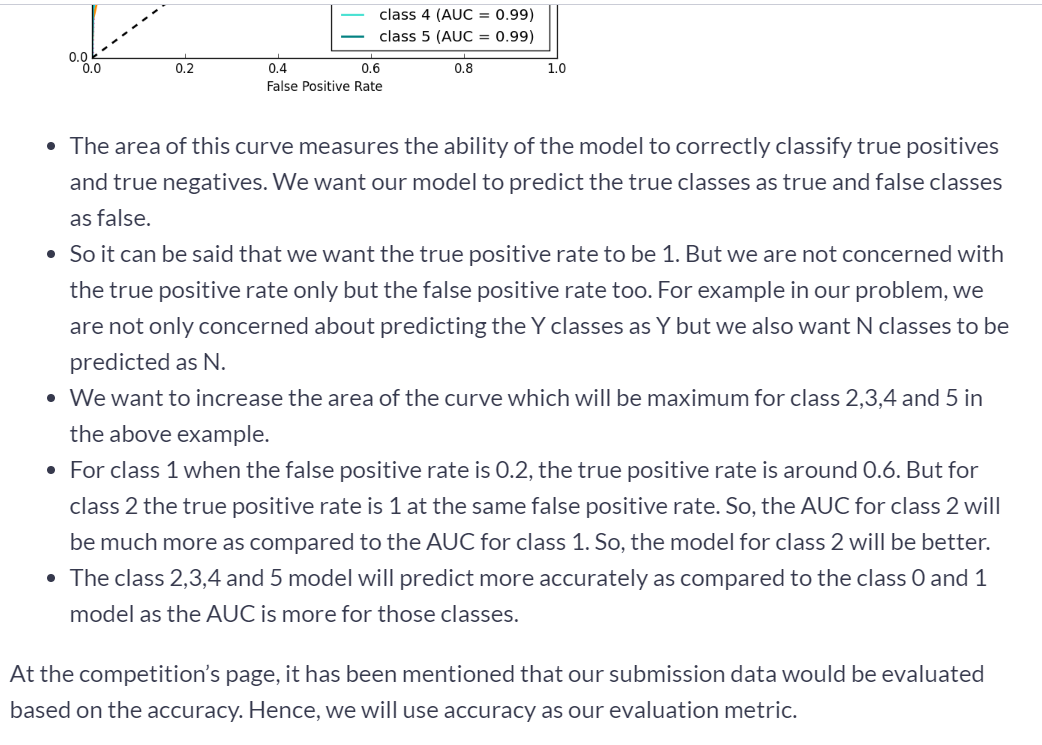

## Model Building Part - 1

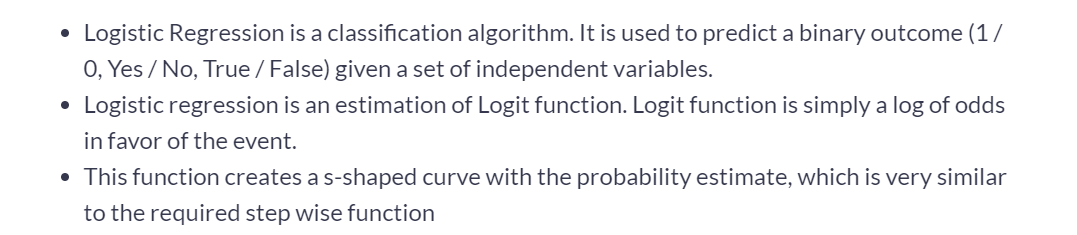

In [364]:
train_original = train.copy()
test_original = test.copy()

In [365]:
# Lets drop the Loan ID column as it do not have any affect on the loan status
train.drop('Loan_ID',axis=1,inplace=True)
test.drop('Loan_ID',axis=1,inplace=True)

In [366]:
x = train.drop('Loan_Status',axis=1)
print(x.shape)
y = train['Loan_Status']
print(y.shape)

(614, 12)
(614,)


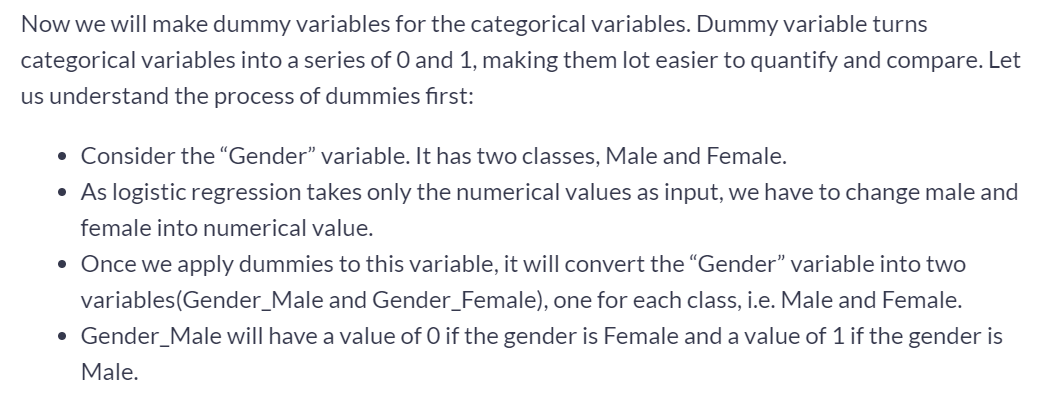

In [367]:
print(x.head())
x = pd.get_dummies(x)
print(x.head())

  Gender Married Dependents     Education Self_Employed  ApplicantIncome  \
0   Male      No          0      Graduate            No             5849   
1   Male     Yes          1      Graduate            No             4583   
2   Male     Yes          0      Graduate           Yes             3000   
3   Male     Yes          0  Not Graduate            No             2583   
4   Male      No          0      Graduate            No             6000   

   CoapplicantIncome  LoanAmount  Loan_Amount_Term  Credit_History  \
0                0.0       128.0             360.0             1.0   
1             1508.0       128.0             360.0             1.0   
2                0.0        66.0             360.0             1.0   
3             2358.0       120.0             360.0             1.0   
4                0.0       141.0             360.0             1.0   

  Property_Area  LoanAmount_log  
0         Urban        4.852030  
1         Rural        4.852030  
2         Urban     

In [368]:
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [369]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=42,stratify=y)
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(429, 21)
(185, 21)
(429,)
(185,)


In [370]:
log_clf = LogisticRegression()
log_clf.fit(x_train,y_train)

LogisticRegression()

In [371]:
y_train_pred = log_clf.predict(x_train)
y_test_pred = log_clf.predict(x_test)

In [372]:
def evaluation(ya,yp):
    cnf_mat = confusion_matrix(ya,yp)
    print("Confusion Matrix: \n",cnf_mat)
    print("*"*80)
    acc = accuracy_score(ya,yp)
    print("Accuracy Score: \n",acc)
    print("*"*80) 
    clf_rpt = classification_report(ya,yp)
    print("Classification Report: \n",clf_rpt)
    print("*"*80)     

In [373]:
print("Training evaluation")
evaluation(y_train,y_train_pred)

Training evaluation
Confusion Matrix: 
 [[ 56  78]
 [ 13 282]]
********************************************************************************
Accuracy Score: 
 0.7878787878787878
********************************************************************************
Classification Report: 
               precision    recall  f1-score   support

           0       0.81      0.42      0.55       134
           1       0.78      0.96      0.86       295

    accuracy                           0.79       429
   macro avg       0.80      0.69      0.71       429
weighted avg       0.79      0.79      0.76       429

********************************************************************************


In [374]:
print("Testing evaluation")
evaluation(y_test,y_test_pred)

Testing evaluation
Confusion Matrix: 
 [[ 32  26]
 [  7 120]]
********************************************************************************
Accuracy Score: 
 0.8216216216216217
********************************************************************************
Classification Report: 
               precision    recall  f1-score   support

           0       0.82      0.55      0.66        58
           1       0.82      0.94      0.88       127

    accuracy                           0.82       185
   macro avg       0.82      0.75      0.77       185
weighted avg       0.82      0.82      0.81       185

********************************************************************************


In [375]:
# Making prediction on test data
pred_test = log_clf.predict(test)

In [376]:
# updating submission file with results
submission = pd.read_csv('sample_submission.csv')
submission

,Loan_ID,Loan_Status
0,LP001015,N
1,LP001022,N
2,LP001031,N
3,LP001035,N
4,LP001051,N
...,...,...
362,LP002971,N
363,LP002975,N
364,LP002980,N
365,LP002986,N


In [377]:
submission['Loan_Status'] = pred_test
submission['Loan_ID'] = test_original['Loan_ID']

In [378]:
submission.head()

,Loan_ID,Loan_Status
0,LP001015,1
1,LP001022,1
2,LP001031,1
3,LP001035,1
4,LP001051,1


In [379]:
#converting prediction to original format
submission['Loan_Status'].replace({0:'N',1:'Y'},inplace=True)

In [380]:
submission.head()

,Loan_ID,Loan_Status
0,LP001015,Y
1,LP001022,Y
2,LP001031,Y
3,LP001035,Y
4,LP001051,Y


In [381]:
submission['Loan_Status'].value_counts()

Y    303
N     64
Name: Loan_Status, dtype: int64

In [382]:
pd.DataFrame(submission,columns=['Loan_ID','Loan_Status']).to_csv('logistic.csv')

## Cross Validation

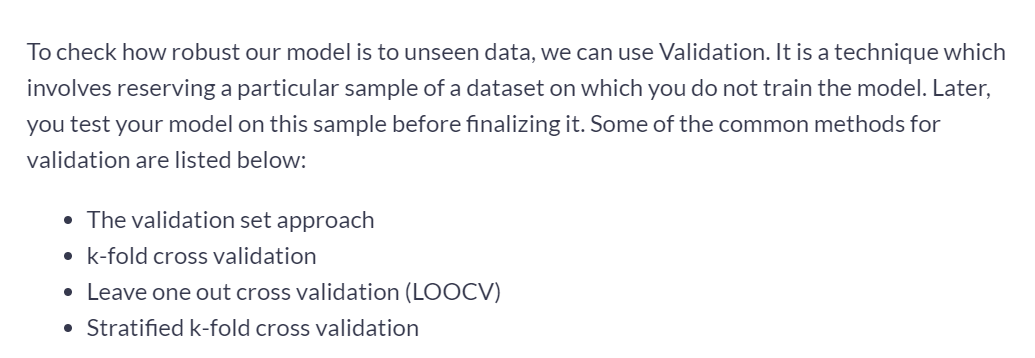

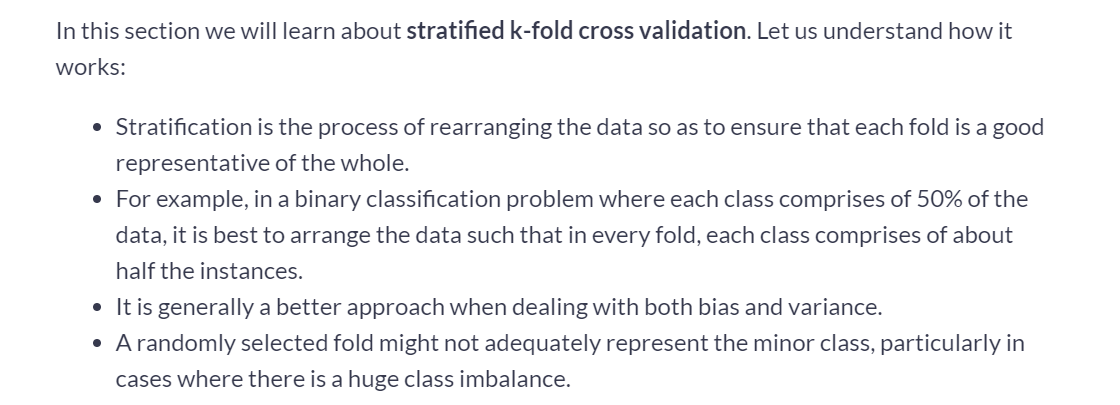

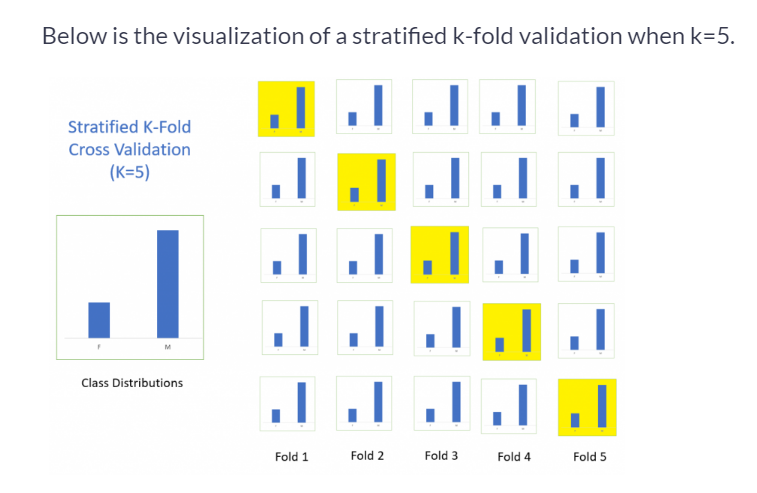

In [383]:
i = 1
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
acc_list = []
for train_index,test_index in kf.split(x,y):
    print("\n{} of kfold {}".format(i,kf.n_splits))
    xtr,xvl = x.iloc[train_index],x.iloc[test_index]
    ytr,yvl = y.iloc[train_index],y.iloc[test_index]
    model = LogisticRegression(random_state=42)
    model.fit(xtr,ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print("Accuracy Score: ",score)
    acc_list.append(score)
    i+=1
    
pred_test = model.predict(test)
pred = model.predict_proba(xvl)[:,1]
    


1 of kfold 5
Accuracy Score:  0.8211382113821138

2 of kfold 5
Accuracy Score:  0.7886178861788617

3 of kfold 5
Accuracy Score:  0.7886178861788617

4 of kfold 5
Accuracy Score:  0.7642276422764228

5 of kfold 5
Accuracy Score:  0.8360655737704918


In [384]:
print("The mean accuracy for this model is : ",np.mean(acc_list))

The mean accuracy for this model is :  0.7997334399573504


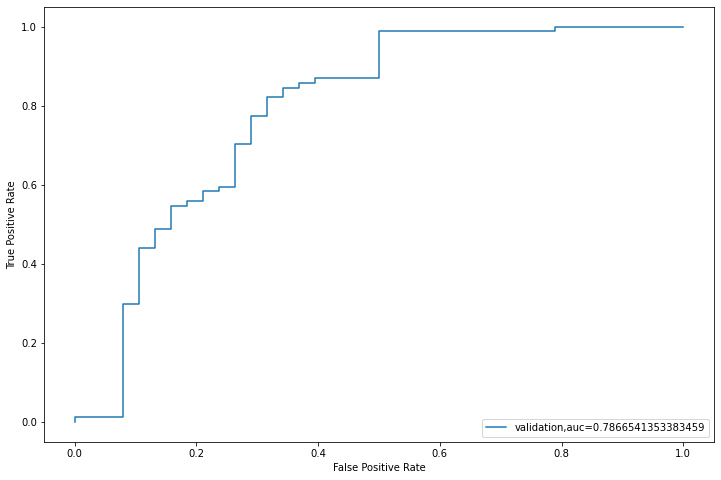

In [385]:
#plot roc curve
fpr,tpr,_ = roc_curve(yvl,pred)
auc = roc_auc_score(yvl,pred)
plt.figure(figsize=(12,8))
plt.plot(fpr,tpr,label='validation,auc='+str(auc))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc=4)
plt.show()

In [386]:
submission['Loan_Status'] = pred_test
submission['Loan_ID'] = test_original['Loan_ID']
submission['Loan_Status'].replace({0:'N',1:'Y'},inplace=True)


In [387]:
pd.DataFrame(submission,columns=['Loan_ID','Loan_Status']).to_csv('Logistic.csv')

## Feature Engineering

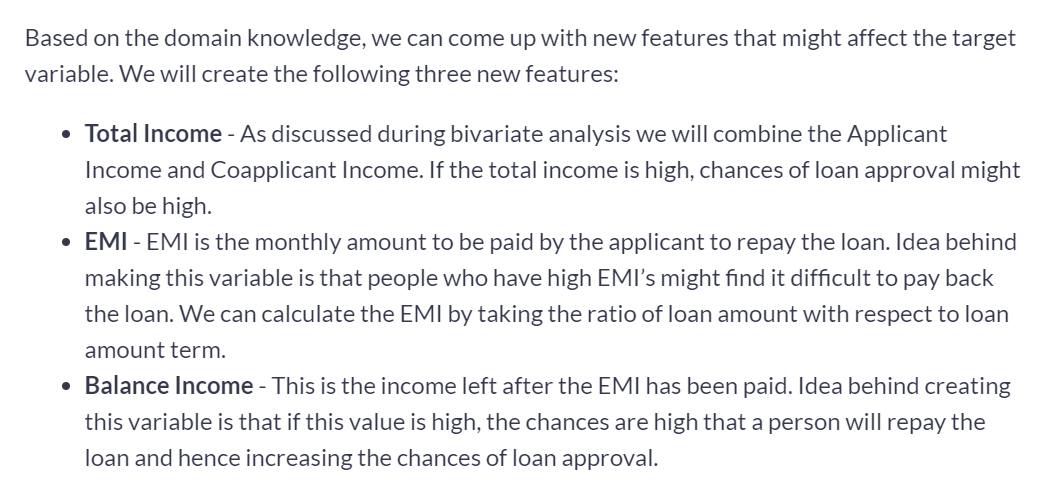

In [388]:
train['Total_Income'] = train['ApplicantIncome'] + train['CoapplicantIncome']
test['Total_Income'] = test['ApplicantIncome'] + test['CoapplicantIncome']


<AxesSubplot:xlabel='Total_Income', ylabel='Density'>

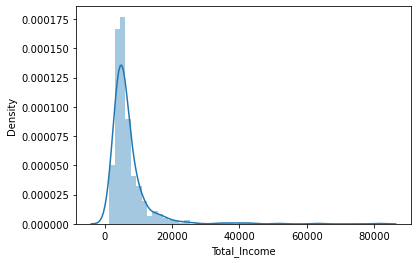

In [389]:
sns.distplot(train['Total_Income'])

<AxesSubplot:xlabel='Total_Income_log', ylabel='Density'>

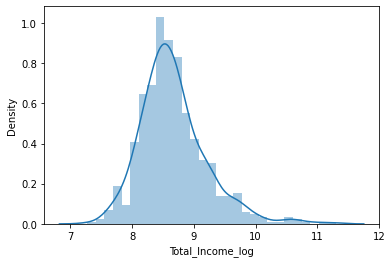

In [390]:
train['Total_Income_log'] = np.log(train['Total_Income'])
test['Total_Income_log'] = np.log(test['Total_Income'])

sns.distplot(train['Total_Income_log'])

In [391]:
train['EMI'] = train['LoanAmount']/train['Loan_Amount_Term']
test['EMI'] = test['LoanAmount']/test['Loan_Amount_Term']


<AxesSubplot:xlabel='EMI', ylabel='Density'>

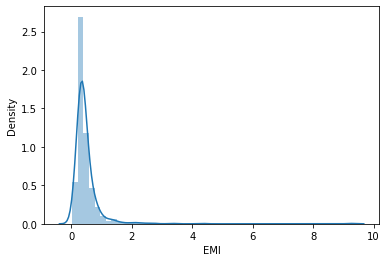

In [392]:
sns.distplot(train['EMI'])

In [393]:
train['Balance_Income'] = train['Total_Income'] - (train['EMI']*1000)
# multiply by 1000 to make units equal
test['Balance_Income'] = test['Total_Income'] - (test['EMI']*1000)


<AxesSubplot:xlabel='Balance_Income', ylabel='Density'>

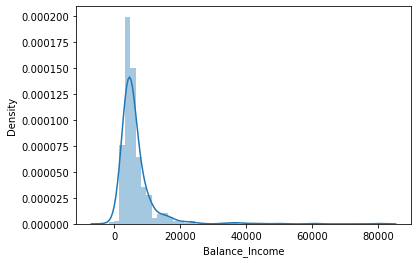

In [394]:
sns.distplot(train['Balance_Income'])

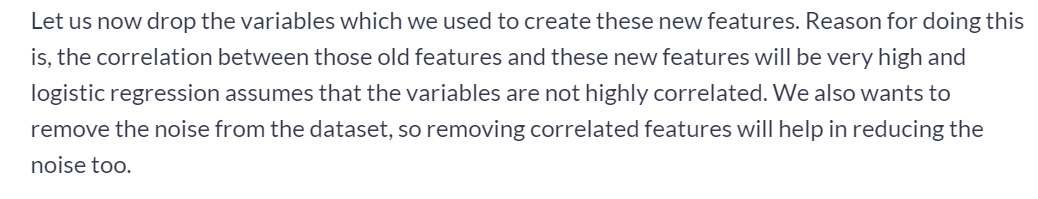

In [395]:
train.columns

Index(['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Loan_Status', 'LoanAmount_log',
       'Gender_Female', 'Gender_Male', 'Married_No', 'Married_Yes',
       'Dependents_3', 'Dependents_0', 'Dependents_1', 'Dependents_2',
       'Education_Graduate', 'Education_Not Graduate', 'Self_Employed_No',
       'Self_Employed_Yes', 'Property_Area_Rural', 'Property_Area_Semiurban',
       'Property_Area_Urban', 'Total_Income', 'Total_Income_log', 'EMI',
       'Balance_Income'],
      dtype='object')

In [396]:
train = train.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Total_Income'],axis=1)
test = test.drop(['ApplicantIncome','CoapplicantIncome','LoanAmount','Loan_Amount_Term','Total_Income'],axis=1)

## Model Building II 

In [397]:
X = train.drop('Loan_Status',axis=1)
y = train['Loan_Status']
print(X.shape)
print(y.shape)

(614, 20)
(614,)


### Logistic Regression

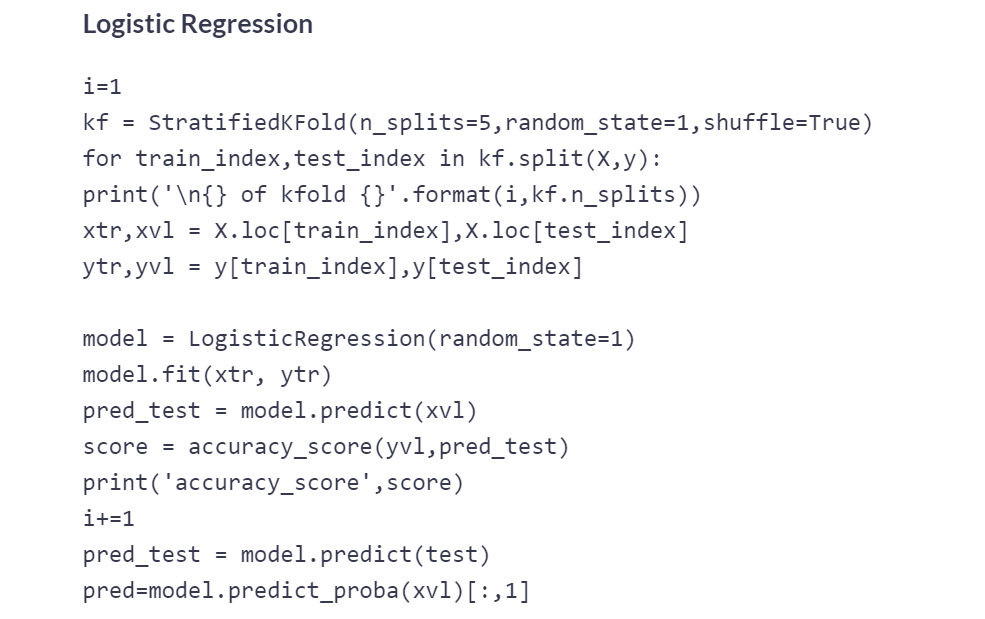

In [398]:
i = 1
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
acc_list = []

for train_index,test_index in kf.split(X,y):
    print("\n {} of kfold {}: ".format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.iloc[test_index]
    ytr,yvl = y.loc[train_index],y.iloc[test_index]
    
    model = LogisticRegression(random_state=42)
    model.fit(xtr,ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print("Accuracy Score: ",score)
    acc_list.append(score)
    i+=1
    
pred_test = model.predict(test)
pred = model.predict_proba(xvl)[:,1]


 1 of kfold 5: 
Accuracy Score:  0.8130081300813008

 2 of kfold 5: 
Accuracy Score:  0.7967479674796748

 3 of kfold 5: 
Accuracy Score:  0.6829268292682927

 4 of kfold 5: 
Accuracy Score:  0.7723577235772358

 5 of kfold 5: 
Accuracy Score:  0.8278688524590164


In [399]:
print("The mean validation accuracy is : ",np.mean(acc_list))

The mean validation accuracy is :  0.7785819005731042


In [400]:
submission['Loan_Status'] = pred_test
submission['Loan_ID'] = test_original['Loan_ID']

submission['Loan_Status'].replace({0:'N',1:'Y'},inplace=True)


In [401]:
pd.DataFrame(submission,columns=['Loan_ID','Loan_Status']).to_csv('Log2.csv')

### Decision Tree

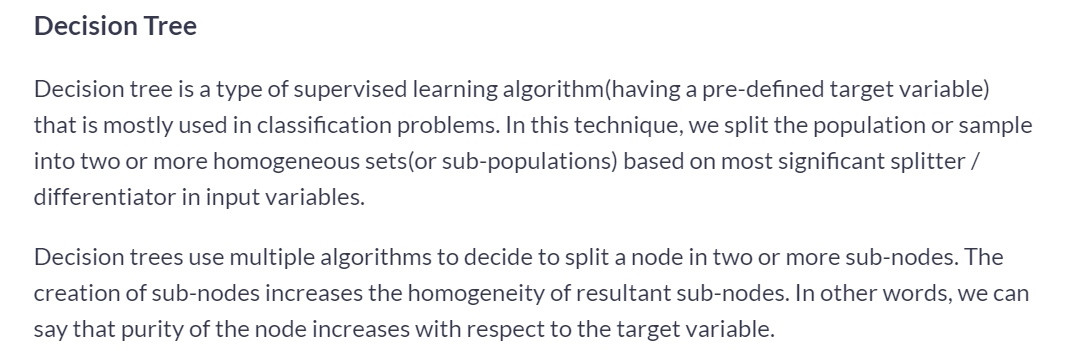

In [402]:
i = 1
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
acc_list = []

for train_index,test_index in kf.split(X,y):
    print("\n {} of kfold {}: ".format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.iloc[test_index]
    ytr,yvl = y.loc[train_index],y.iloc[test_index]
    
    model = DecisionTreeClassifier(random_state=42)
    model.fit(xtr,ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print("Accuracy Score: ",score)
    acc_list.append(score)
    i+=1
    
pred_test = model.predict(test)


 1 of kfold 5: 
Accuracy Score:  0.6829268292682927

 2 of kfold 5: 
Accuracy Score:  0.7398373983739838

 3 of kfold 5: 
Accuracy Score:  0.6666666666666666

 4 of kfold 5: 
Accuracy Score:  0.6991869918699187

 5 of kfold 5: 
Accuracy Score:  0.7377049180327869


In [403]:
print("The mean validation accuracy is : ",np.mean(acc_list))

The mean validation accuracy is :  0.7052645608423298


In [404]:
submission['Loan_Status'] = pred_test
submission['Loan_ID'] = test_original['Loan_ID']

submission['Loan_Status'].replace({0:'N',1:'Y'},inplace=True)


In [405]:
pd.DataFrame(submission,columns=['Loan_ID','Loan_Status']).to_csv('Decision Tree.csv')

### Random Forest

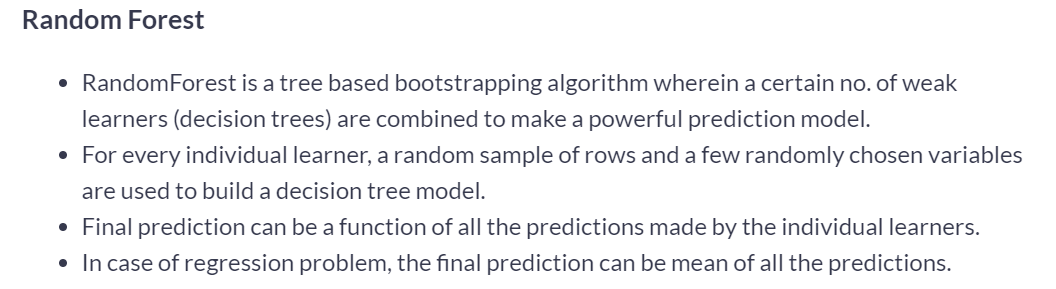

In [406]:
i = 1
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
acc_list = []

for train_index,test_index in kf.split(X,y):
    print("\n {} of kfold {}: ".format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.iloc[test_index]
    ytr,yvl = y.loc[train_index],y.iloc[test_index]
    
    model = RandomForestClassifier(random_state=42,max_depth=10)
    model.fit(xtr,ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print("Accuracy Score: ",score)
    acc_list.append(score)
    i+=1
    
pred_test = model.predict(test)


 1 of kfold 5: 
Accuracy Score:  0.8211382113821138

 2 of kfold 5: 
Accuracy Score:  0.8130081300813008

 3 of kfold 5: 
Accuracy Score:  0.7967479674796748

 4 of kfold 5: 
Accuracy Score:  0.7804878048780488

 5 of kfold 5: 
Accuracy Score:  0.8032786885245902


In [407]:
print("The mean validation accuracy is : ",np.mean(acc_list))

The mean validation accuracy is :  0.8029321604691457


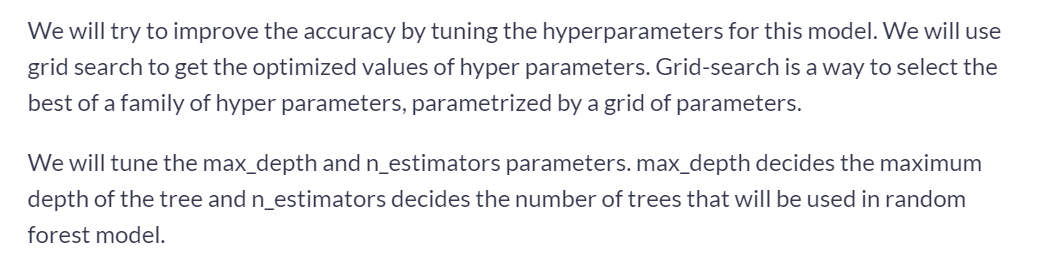

In [408]:
paramgrid = {'max_depth' : list(range(1,20,2)),
            'n_estimators' : list(range(1,200,20))}

gscv_rf = GridSearchCV(RandomForestClassifier(random_state=42),paramgrid)

x_train,x_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

gscv_rf.fit(x_train,y_train)


GridSearchCV(estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19],
                         'n_estimators': [1, 21, 41, 61, 81, 101, 121, 141, 161,
                                          181]})

In [409]:
gscv_rf.best_params_

{'max_depth': 5, 'n_estimators': 141}

In [410]:
i = 1
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
acc_list = []

for train_index,test_index in kf.split(X,y):
    print("\n {} of kfold {}: ".format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.iloc[test_index]
    ytr,yvl = y.loc[train_index],y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=41,random_state=42,max_depth=5)
    model.fit(xtr,ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print("Accuracy Score: ",score)
    acc_list.append(score)
    i+=1
    
pred_test = model.predict(test)


 1 of kfold 5: 
Accuracy Score:  0.7967479674796748

 2 of kfold 5: 
Accuracy Score:  0.8211382113821138

 3 of kfold 5: 
Accuracy Score:  0.7967479674796748

 4 of kfold 5: 
Accuracy Score:  0.7967479674796748

 5 of kfold 5: 
Accuracy Score:  0.8278688524590164


In [411]:
print("The mean validation accuracy is : ",np.mean(acc_list))

The mean validation accuracy is :  0.8078501932560309


In [412]:
submission['Loan_Status'] = pred_test
submission['Loan_ID'] = test_original['Loan_ID']

submission['Loan_Status'].replace({0:'N',1:'Y'},inplace=True)


In [413]:
pd.DataFrame(submission,columns=['Loan_ID','Loan_Status']).to_csv('Random Forest.csv')

<AxesSubplot:>

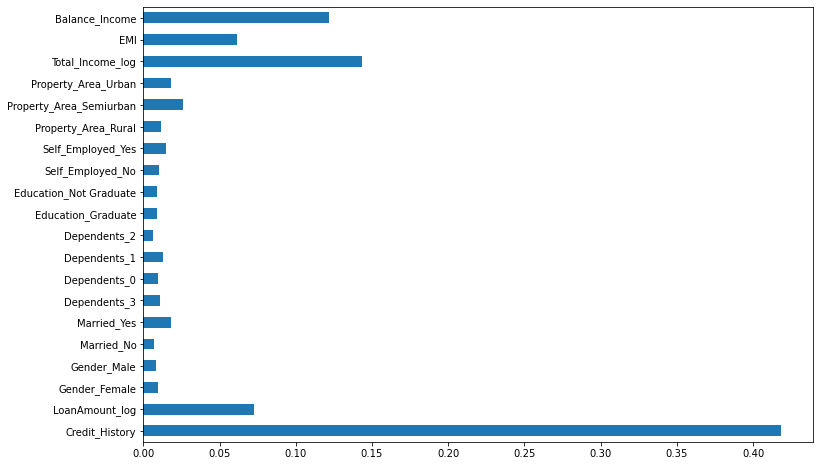

In [414]:
importances = pd.Series(model.feature_importances_,index = X.columns)
importances.plot(kind='barh',figsize=(12,8))

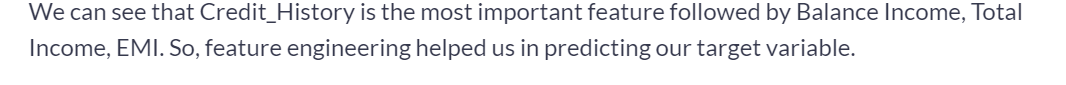

### XGBoost

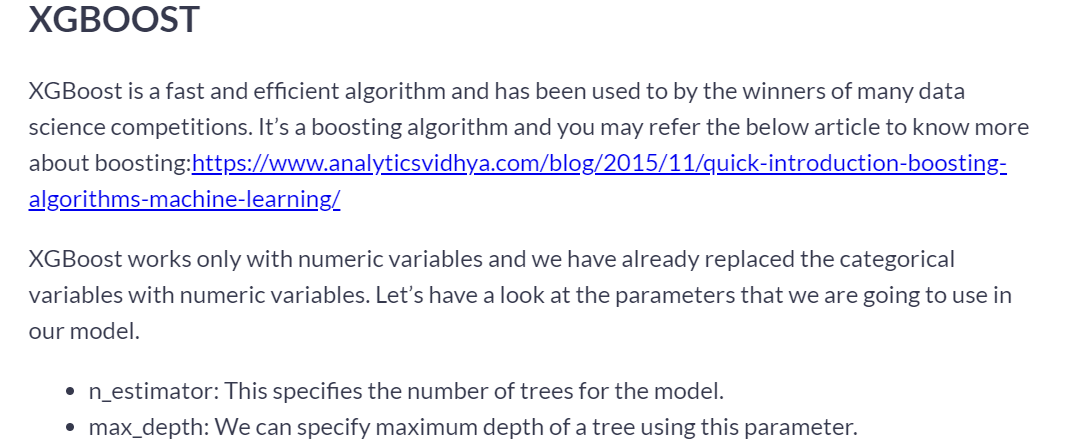

In [415]:
i = 1
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
acc_list = []

for train_index,test_index in kf.split(X,y):
    print("\n {} of kfold {}: ".format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.iloc[test_index]
    ytr,yvl = y.loc[train_index],y.iloc[test_index]
    
    model = XGBClassifier(n_estimators=50,max_depth=4)
    model.fit(xtr,ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print("Accuracy Score: ",score)
    acc_list.append(score)
    i+=1
    
pred_test = model.predict(test)
pred3 = model.predict_proba(test)[:,1]


 1 of kfold 5: 
Accuracy Score:  0.7723577235772358

 2 of kfold 5: 
Accuracy Score:  0.8048780487804879

 3 of kfold 5: 
Accuracy Score:  0.7560975609756098

 4 of kfold 5: 
Accuracy Score:  0.7804878048780488

 5 of kfold 5: 
Accuracy Score:  0.7868852459016393


In [416]:
print("The mean validation accuracy is : ",np.mean(acc_list))

The mean validation accuracy is :  0.7801412768226041


In [417]:
submission['Loan_Status'] = pred_test
submission['Loan_ID'] = test_original['Loan_ID']

submission['Loan_Status'].replace({0:'N',1:'Y'},inplace=True)


In [418]:
pd.DataFrame(submission,columns=['Loan_ID','Loan_Status']).to_csv('XGBoost.csv')

### Model Comparision

In [419]:
Model_Metrics = {
    'Model':
    ['Logistic_Regression', 'Decision_Tree', 'Random_Forest', 'XGBoost'],
    'Accuracy': [77, 71, 80, 78]
}

Model_Metrics

{'Model': ['Logistic_Regression', 'Decision_Tree', 'Random_Forest', 'XGBoost'],
 'Accuracy': [77, 71, 80, 78]}

In [420]:
model_comp = pd.DataFrame(Model_Metrics['Accuracy'],index=Model_Metrics['Model'],columns=['Accuracy'])
model_comp

,Accuracy
Logistic_Regression,77
Decision_Tree,71
Random_Forest,80
XGBoost,78


<AxesSubplot:>

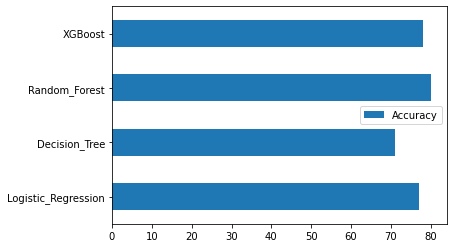

In [421]:
model_comp.plot(kind='barh')

## Building finalized model and user input testing

In [465]:
X = train.drop('Loan_Status',axis=1)
y = train['Loan_Status']
print(X.shape)
print(y.shape)

(614, 20)
(614,)


In [466]:
i = 1
kf = StratifiedKFold(n_splits=5,random_state=42,shuffle=True)
acc_list = []

for train_index,test_index in kf.split(X,y):
    print("\n {} of kfold {}: ".format(i,kf.n_splits))
    xtr,xvl = X.loc[train_index],X.iloc[test_index]
    ytr,yvl = y.loc[train_index],y.iloc[test_index]
    
    model = RandomForestClassifier(n_estimators=41,random_state=42,max_depth=5)
    model.fit(xtr,ytr)
    pred_test = model.predict(xvl)
    score = accuracy_score(yvl,pred_test)
    print("Accuracy Score: ",score)
    acc_list.append(score)
    
    if i==2:
        x_train,x_test,y_train,y_test = xtr,xvl,ytr,yvl
    i+=1
    
pred_test = model.predict(test)


 1 of kfold 5: 
Accuracy Score:  0.7967479674796748

 2 of kfold 5: 
Accuracy Score:  0.8211382113821138

 3 of kfold 5: 
Accuracy Score:  0.7967479674796748

 4 of kfold 5: 
Accuracy Score:  0.7967479674796748

 5 of kfold 5: 
Accuracy Score:  0.8278688524590164


In [467]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(491, 20)
(123, 20)
(491,)
(123,)


In [468]:
model = RandomForestClassifier(n_estimators=41,random_state=42,max_depth=5)
model.fit(x_train,y_train)

RandomForestClassifier(max_depth=5, n_estimators=41, random_state=42)

In [469]:
y_test_pred = model.predict(x_test)
y_train_pred = model.predict(x_train)

In [470]:
print("Testing Evaluation")
evaluation(y_test,y_test_pred)

Testing Evaluation
Confusion Matrix: 
 [[18 20]
 [ 2 83]]
********************************************************************************
Accuracy Score: 
 0.8211382113821138
********************************************************************************
Classification Report: 
               precision    recall  f1-score   support

           0       0.90      0.47      0.62        38
           1       0.81      0.98      0.88        85

    accuracy                           0.82       123
   macro avg       0.85      0.73      0.75       123
weighted avg       0.83      0.82      0.80       123

********************************************************************************


In [471]:
print("Training Evaluation")
evaluation(y_train,y_train_pred)

Training Evaluation
Confusion Matrix: 
 [[ 76  78]
 [  3 334]]
********************************************************************************
Accuracy Score: 
 0.835030549898167
********************************************************************************
Classification Report: 
               precision    recall  f1-score   support

           0       0.96      0.49      0.65       154
           1       0.81      0.99      0.89       337

    accuracy                           0.84       491
   macro avg       0.89      0.74      0.77       491
weighted avg       0.86      0.84      0.82       491

********************************************************************************


- Here we have high precision and low recall as we need more focus on False Positive 
- Precision = TruePositives / (TruePositives + FalsePositives)
- FalsePositives for classfication 0-->'N' : Actual Y, Predicted N
- It means we did not approve loan for the customers who could repay leading to customer loss and buissness
- Hence we need to focus on minimizing it by getting High Precision

In [503]:
encoder = {'columns':X.columns.to_list(),
          'target':{0:'N',1:'Y'},
          'Dependents':{'0':0,'1':1,'2':2,'3+':3}}
encoder

{'columns': ['Credit_History',
  'LoanAmount_log',
  'Gender_Female',
  'Gender_Male',
  'Married_No',
  'Married_Yes',
  'Dependents_3',
  'Dependents_0',
  'Dependents_1',
  'Dependents_2',
  'Education_Graduate',
  'Education_Not Graduate',
  'Self_Employed_No',
  'Self_Employed_Yes',
  'Property_Area_Rural',
  'Property_Area_Semiurban',
  'Property_Area_Urban',
  'Total_Income_log',
  'EMI',
  'Balance_Income'],
 'target': {0: 'N', 1: 'Y'},
 'Dependents': {'0': 0, '1': 1, '2': 2, '3+': 3}}

In [504]:
with open('Loan_encoder.json','w') as f:
    json.dump(encoder,f)

In [474]:
model

RandomForestClassifier(max_depth=5, n_estimators=41, random_state=42)

In [475]:
with open('Loan_model.pkl','wb') as f:
    pickle.dump(model,f)

## User Input Testing

In [505]:
with open('Loan_encoder.json','r') as f:
    test_enc = json.load(f)
test_enc

{'columns': ['Credit_History',
  'LoanAmount_log',
  'Gender_Female',
  'Gender_Male',
  'Married_No',
  'Married_Yes',
  'Dependents_3',
  'Dependents_0',
  'Dependents_1',
  'Dependents_2',
  'Education_Graduate',
  'Education_Not Graduate',
  'Self_Employed_No',
  'Self_Employed_Yes',
  'Property_Area_Rural',
  'Property_Area_Semiurban',
  'Property_Area_Urban',
  'Total_Income_log',
  'EMI',
  'Balance_Income'],
 'target': {'0': 'N', '1': 'Y'},
 'Dependents': {'0': 0, '1': 1, '2': 2, '3+': 3}}

In [477]:
with open('Loan_model.pkl','rb') as f:
    test_model = pickle.load(f)
    
test_model

RandomForestClassifier(max_depth=5, n_estimators=41, random_state=42)

In [478]:
test_arr = np.zeros(len(test_enc['columns']))
test_arr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0.])

In [454]:
df = pd.read_csv('train_data.csv')
df.head(1).T

,0
Loan_ID,LP001002
Gender,Male
Married,No
Dependents,0
Education,Graduate
Self_Employed,No
ApplicantIncome,5849
CoapplicantIncome,0.0
LoanAmount,NaN
Loan_Amount_Term,360.0


In [483]:
Gender='Male' 
Married='No' 
Dependents='0'
Education='Graduate'
Self_Employed='No'
ApplicantIncome=5849
CoapplicantIncome=0.0
LoanAmount=128.0
Loan_Amount_Term=360.0 
Credit_History=1.0
Property_Area='Urban' 

In [484]:
#Conversion of categorical to numericals columns
Dependents = test_enc['Dependents'][Dependents]

In [485]:
#Conversion of categorical encoding columns
Gender = "Gender_"+Gender
Gender_index = test_enc['columns'].index(Gender)
print("Gender Index",Gender_index)

Married = "Married_"+Married
Married_index = test_enc['columns'].index(Married)
print("Married Index",Married_index)

Dependents = "Dependents_"+str(Dependents)
Dependents_index = test_enc['columns'].index(Dependents)
print("Dependents Index",Dependents_index)

Education = "Education_"+Education
Education_index = test_enc['columns'].index(Education)
print("Education Index",Education_index)

Self_Employed = "Self_Employed_"+Self_Employed
Self_Employed_index = test_enc['columns'].index(Self_Employed)
print("Self_Employed Index",Self_Employed_index)

Property_Area = "Property_Area_"+Property_Area
Property_Area_index = test_enc['columns'].index(Property_Area)
print("Property_Area Index",Property_Area_index)

Gender Index 3
Married Index 4
Dependents Index 7
Education Index 10
Self_Employed Index 12
Property_Area Index 16


In [493]:
#Creating New columns

Total_Income = ApplicantIncome + CoapplicantIncome
Total_Income_log = np.log(Total_Income)

LoanAmount_log = np.log(LoanAmount)

EMI = LoanAmount/Loan_Amount_Term

Balance_Income = Total_Income - (EMI * 1000)

In [494]:
test_arr[0] = Credit_History #Credit_History
test_arr[1] = LoanAmount_log #LoanAmount_log
test_arr[Gender_index] = 1 #Gender
test_arr[Married_index] = 1 #Married
test_arr[Dependents_index] = 1 #Dependents
test_arr[Education_index] = 1 #Education
test_arr[Self_Employed_index] = 1 #Self_Employed
test_arr[Property_Area_index] = 1 #Property_Area
test_arr[17] = Total_Income_log #Total_Income_log
test_arr[18] = EMI #EMI
test_arr[19] = Balance_Income #Balance_Income

In [495]:
test_arr

array([1.00000000e+00, 4.85203026e+00, 0.00000000e+00, 1.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 1.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 8.67402599e+00, 3.55555556e-01, 5.49344444e+03])

In [500]:
prediction = test_model.predict([test_arr])[0]
prediction

1

In [507]:
prediction = test_enc['target'][str(prediction)]
prediction

'Y'